# Enhanced Data-Driven Hotel Dynamic Pricing Implementation

In [1]:
# Standard libraries
import itertools
import numpy as np
import random
import time
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style directly
sns.set_theme()  # This sets the default seaborn theme
# Or choose a specific style:
sns.set_style("whitegrid")  # Options: "whitegrid", "darkgrid", "white", "dark", "ticks"

# Other imports (if needed)
from concurrent.futures import ProcessPoolExecutor
import logging
from tqdm import tqdm

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
@dataclass
class ProblemParameters:
    """
    Parameters for the hotel dynamic pricing problem.
    
    Attributes:
        N (int): Number of days in service horizon
        T (int): Number of booking periods
        C (int): Total room capacity
        price_min (float): Minimum price
        price_max (float): Maximum price
        price_levels (int): Number of discrete price levels
        arrival_prob_base (float): Base arrival probability for each booking class
    """
    N: int
    T: int
    C: int
    price_min: float
    price_max: float
    price_levels: int
    arrival_prob_base: float

    def validate(self):
        """Validate parameter values."""
        assert self.N > 0, "Service horizon must be positive"
        assert self.T > 0, "Booking periods must be positive"
        assert self.C > 0, "Capacity must be positive"
        assert self.price_min > 0, "Minimum price must be positive"
        assert self.price_max > self.price_min, "Maximum price must be greater than minimum"
        assert self.price_levels > 1, "Need at least 2 price levels"
        assert 0 < self.arrival_prob_base < 1, "Arrival probability must be between 0 and 1"

In [4]:
@dataclass
class BookingClass:
    """
    Booking class representation with additional functionality.
    """
    id: int
    arrival: int
    departure: int
    length: int
    stay_days: List[int]
    consumption_vector: Tuple[int, ...]

    @classmethod
    def create(cls, id: int, arrival: int, departure: int, N: int) -> 'BookingClass':
        """Factory method to create a booking class."""
        if not (1 <= arrival <= departure):
            raise ValueError("Invalid arrival/departure combination")
        
        length = departure - arrival + 1
        stay_days = list(range(arrival, departure + 1))
        consumption_vector = tuple(1 if i+1 in stay_days else 0 for i in range(N))
        
        return cls(id, arrival, departure, length, stay_days, consumption_vector)

In [5]:
class ReservationPriceModel:
    """
    Models customer reservation price distribution and related functions.
    """
    def __init__(self, price_min: float, price_max: float, distribution: str = 'uniform'):
        self.price_min = price_min
        self.price_max = price_max
        self.distribution = distribution
        
    def cdf(self, p: float) -> float:
        """Cumulative distribution function of reservation price."""
        if self.distribution == 'uniform':
            if p < self.price_min:
                return 0.0
            elif p > self.price_max:
                return 1.0
            else:
                return (p - self.price_min) / (self.price_max - self.price_min)
        elif self.distribution == 'exponential':
            # Example of alternative distribution
            lambda_param = 1 / (self.price_max - self.price_min)
            return 1 - np.exp(-lambda_param * (p - self.price_min))
        
    def survival(self, p: float) -> float:
        """Survival function (1 - CDF)."""
        return 1 - self.cdf(p)

    def expected_revenue(self, p: float) -> float:
        """Expected revenue at price p."""
        return p * self.survival(p)

In [6]:
class DynamicPricingModel:
    """
    Core implementation of the dynamic pricing model.
    """
    def __init__(self, params: ProblemParameters):
        self.params = params
        params.validate()
        
        # Initialize components
        self.initialize_booking_classes()
        self.initialize_state_space()
        self.initialize_price_vectors()
        self.initialize_arrival_probabilities()
        self.price_model = ReservationPriceModel(params.price_min, params.price_max)
        
        # Initialize value function and policy
        self.V = {}
        self.policy = {}
        self.reset_value_function()
        
    def initialize_booking_classes(self):
        """Initialize all possible booking classes."""
        self.booking_classes = []
        id_counter = 1
        
        for a, d in itertools.product(range(1, self.params.N + 1), repeat=2):
            if a <= d:
                try:
                    bc = BookingClass.create(id_counter, a, d, self.params.N)
                    self.booking_classes.append(bc)
                    id_counter += 1
                except ValueError as e:
                    logger.warning(f"Skipping invalid booking class: {e}")
                    
    def initialize_state_space(self):
        """Generate all possible states."""
        self.states = list(itertools.product(
            range(self.params.C + 1), 
            repeat=self.params.N
        ))
        
    def initialize_price_vectors(self):
        """Generate price vectors with specified levels."""
        prices = np.linspace(
            self.params.price_min,
            self.params.price_max,
            self.params.price_levels
        )
        self.price_vectors = list(itertools.product(prices, repeat=self.params.N))
        
    def initialize_arrival_probabilities(self):
        """Initialize arrival probabilities for each booking class and time period."""
        self.pi = {t: {} for t in range(1, self.params.T + 1)}
        
        # Adjust probabilities to ensure sum <= 1 for each period
        base_prob = self.params.arrival_prob_base
        num_classes = len(self.booking_classes)
        adjusted_prob = min(base_prob, 1.0 / num_classes)
        
        for t in range(1, self.params.T + 1):
            for bc in self.booking_classes:
                self.pi[t][bc.id] = adjusted_prob
                
    def reset_value_function(self):
        """Reset value function and policy to initial state."""
        self.V = {state: {t: 0.0 for t in range(1, self.params.T + 2)} 
                 for state in self.states}
        self.policy = {state: {t: None for t in range(1, self.params.T + 1)} 
                      for state in self.states}
        
    def is_available(self, state: Tuple[int, ...], bc: BookingClass) -> bool:
        """Check if booking can be accommodated."""
        return all(state[i] >= bc.consumption_vector[i] for i in range(self.params.N))
    
    def update_state(self, state: Tuple[int, ...], bc: BookingClass) -> Tuple[int, ...]:
        """Update state after accepting a booking."""
        return tuple(s - c for s, c in zip(state, bc.consumption_vector))
    
    def calculate_expected_revenue(self, state: Tuple[int, ...], price_vector: Tuple[float, ...], t: int) -> float:
        """Calculate expected revenue for a given state and price vector."""
        total_expected_value = 0.0
        base_future_value = self.V[state][t+1]  # V(x_t, t+1)

        for bc in self.booking_classes:
            if not self.is_available(state, bc):
                continue

            # Calculate average price for booking class
            stay_prices = [price_vector[day - 1] for day in bc.stay_days]
            avg_price = np.mean(stay_prices)

            # Calculate acceptance probability and expected demand
            acceptance_prob = self.price_model.survival(avg_price)
            # lambda_tb = self.pi[t][bc.id] * acceptance_prob
            u_tb = self.pi[t][bc.id] * acceptance_prob
            
            # Calculate new state value
            new_state = self.update_state(state, bc)
            
            # Calculate marginal value: L^b * p̄_t^b + V(x_t - e^b, t+1) - V(x_t, t+1)
            marginal_value = (bc.length * avg_price + 
                             self.V[new_state][t+1] - 
                             base_future_value)

            total_expected_value += u_tb * marginal_value

        return total_expected_value + base_future_value
        
    def solve(self, use_parallel: bool = False):
        """
        Solve the dynamic pricing problem.
        
        Args:
            use_parallel (bool): Whether to use parallel processing
        """
        start_time = time.time()
        logger.info("Starting solution process...")

        try:
            if use_parallel and __name__ == '__main__':
                self._solve_parallel()
            else:
                self._solve_sequential()
        except Exception as e:
            logger.error(f"Error during solving: {str(e)}")
            logger.info("Falling back to sequential processing")
            self._solve_sequential()

        elapsed_time = time.time() - start_time
        logger.info(f"Solution completed in {elapsed_time:.2f} seconds")
                
    def _solve_sequential(self):
        """Sequential solution method."""
        for t in range(self.params.T, 0, -1):
            logger.info(f"Processing time period {t}")
            for state in tqdm(self.states, desc=f"Processing states for t={t}"):
                result = self._process_state(state, t)
                # Unpack the result correctly based on what _process_state returns
                max_revenue, optimal_price = result[1], result[2]
                self.V[state][t] = max_revenue
                self.policy[state][t] = optimal_price
    
    def _process_state(self, state: Tuple[int, ...], t: int) -> Tuple[Tuple[int, ...], float, Tuple[float, ...]]:
        """
        Process a single state.
        
        Returns:
            Tuple containing (state, max_revenue, optimal_price_vector)
        """
        max_revenue = float('-inf')
        optimal_price_vector = None

        for price_vector in self.price_vectors:
            total_expected_revenue = self.calculate_expected_revenue(state, price_vector, t)
            
            if total_expected_revenue > max_revenue:
                max_revenue = total_expected_revenue
                optimal_price_vector = price_vector

        return state, max_revenue, optimal_price_vector
    
    
    
    def _solve_parallel(self):
        """Parallel solution method using ProcessPoolExecutor."""
        if __name__ != '__main__':
            logger.warning("Parallel processing not available in interactive mode")
            return self._solve_sequential()

        for t in range(self.params.T, 0, -1):
            logger.info(f"Processing time period {t}")
            try:
                with ProcessPoolExecutor() as executor:
                    futures = []
                    for state in self.states:
                        futures.append(
                            executor.submit(self._process_state, state, t)
                        )
                    
                    for state, future in tqdm(zip(self.states, futures), 
                                           total=len(self.states),
                                           desc=f"Processing states for t={t}"):
                        try:
                            result = future.result()
                            # Unpack the result correctly
                            _, max_revenue, optimal_price = result
                            self.V[state][t] = max_revenue
                            self.policy[state][t] = optimal_price
                        except Exception as e:
                            logger.error(f"Error processing state {state}: {str(e)}")
                            
            except Exception as e:
                logger.error(f"Error in parallel processing: {str(e)}")
                logger.info("Falling back to sequential processing for this time period")
                for state in tqdm(self.states, desc=f"Processing states for t={t}"):
                    result = self._process_state(state, t)
                    max_revenue, optimal_price = result[1], result[2]
                    self.V[state][t] = max_revenue
                    self.policy[state][t] = optimal_price
                    
    def visualize_results(self):
        """
        Comprehensive visualization of results.
        """
        # Create a figure for organizing all plots
        # plt.style.use('seaborn')
        
        # 1. Pricing Policy Visualization
        self._plot_pricing_policy_3d()
        
        # 2. Value Function Analysis
        self._plot_value_function()
        
        # 3. Price Distributions and Statistics
        self._plot_price_distributions()
        
        # 4. Booking Class Analysis
        self._plot_booking_class_analysis()
        
        # 5. State Transition Analysis
        self._plot_state_transitions()
        
        plt.tight_layout()
        plt.show()
        
    def _plot_pricing_policy_3d(self):
        """
        Plot 3D visualization of pricing policies for different states.
        Shows how optimal prices vary with available capacity for each day.
        """
        try:
            # Create subplots for each time period
            for t in range(1, self.params.T + 1):
                fig = plt.figure(figsize=(12, 8))
                ax = fig.add_subplot(111, projection='3d')

                # Prepare data
                x1, x2, x3, prices = [], [], [], []
                for state in self.states:
                    if self.policy[state][t] is not None:  # Check if policy exists
                        x1.append(state[0])  # Day 1 capacity
                        x2.append(state[1])  # Day 2 capacity
                        x3.append(state[2])  # Day 3 capacity
                        avg_price = np.mean(self.policy[state][t])
                        prices.append(avg_price)

                # Convert to numpy arrays for better compatibility
                x1 = np.array(x1)
                x2 = np.array(x2)
                x3 = np.array(x3)
                prices = np.array(prices)

                # Check if we have data to plot
                if len(prices) == 0:
                    logger.warning(f"No data to plot for time period {t}")
                    continue

                # Create color normalization
                norm = plt.Normalize(prices.min(), prices.max())
                colors = plt.cm.viridis(norm(prices))

                # Create scatter plot with explicit sizes
                scatter = ax.scatter(x1, x2, x3, 
                                   c=colors,
                                   s=50,  # explicit point size
                                   alpha=0.6)

                # Labels and title
                ax.set_xlabel('Available Rooms Day 1')
                ax.set_ylabel('Available Rooms Day 2')
                ax.set_zlabel('Available Rooms Day 3')
                ax.set_title(f'Optimal Average Pricing Policy (t={t})')

                # Create custom colorbar
                sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
                sm.set_array([])
                cbar = plt.colorbar(sm)
                cbar.set_label('Average Price ($)')

                # Optional: Add grid
                ax.grid(True)

                # Optional: Set viewing angle
                ax.view_init(elev=20, azim=45)

                # Optional: Set axis limits
                ax.set_xlim(0, self.params.C)
                ax.set_ylim(0, self.params.C)
                ax.set_zlim(0, self.params.C)

                plt.tight_layout()

        except Exception as e:
            logger.error(f"Error in 3D plotting: {str(e)}")
            # Fallback to 2D visualization
            self._plot_pricing_policy_2d(t)

    def _plot_pricing_policy_2d(self, t):
        """
        Fallback 2D visualization of pricing policies.
        Creates a series of 2D plots for different capacity levels of day 3.
        """
        # Create a grid of subplots for different day 3 capacities
        n_plots = self.params.C + 1
        n_cols = min(3, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, 
                                figsize=(5*n_cols, 4*n_rows),
                                squeeze=False)
        fig.suptitle(f'Pricing Policy Slices (t={t})')

        for day3_capacity in range(self.params.C + 1):
            row = day3_capacity // n_cols
            col = day3_capacity % n_cols
            ax = axes[row, col]

            # Prepare data for this slice
            x1, x2, prices = [], [], []
            for state in self.states:
                if (self.policy[state][t] is not None and 
                    state[2] == day3_capacity):
                    x1.append(state[0])
                    x2.append(state[1])
                    prices.append(np.mean(self.policy[state][t]))

            if len(prices) > 0:
                # Create heatmap for this slice
                x1_unique = sorted(set(x1))
                x2_unique = sorted(set(x2))
                price_grid = np.full((len(x1_unique), len(x2_unique)), np.nan)

                for i, j, p in zip(x1, x2, prices):
                    i_idx = x1_unique.index(i)
                    j_idx = x2_unique.index(j)
                    price_grid[i_idx, j_idx] = p

                im = ax.imshow(price_grid.T, origin='lower', 
                              aspect='equal', cmap='viridis')

                # Labels
                ax.set_xlabel('Day 1 Capacity')
                ax.set_ylabel('Day 2 Capacity')
                ax.set_title(f'Day 3 Capacity = {day3_capacity}')

                # Add colorbar
                plt.colorbar(im, ax=ax)

            else:
                ax.text(0.5, 0.5, 'No Data',
                       horizontalalignment='center',
                       verticalalignment='center')

            # Set ticks
            ax.set_xticks(range(len(x1_unique)))
            ax.set_yticks(range(len(x2_unique)))
            ax.set_xticklabels(x1_unique)
            ax.set_yticklabels(x2_unique)

        # Remove empty subplots if any
        for idx in range(day3_capacity + 1, n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            fig.delaxes(axes[row, col])

        plt.tight_layout()
    
    def _plot_value_function(self):
        """
        Visualize the value function across different states and time periods.
        Shows expected revenue potential for different states.
        """
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Value function vs total capacity
        plt.subplot(131)
        for t in range(1, self.params.T + 1):
            x = [sum(state) for state in self.states]
            y = [self.V[state][t] for state in self.states]
            plt.scatter(x, y, alpha=0.5, label=f't={t}')
        
        plt.xlabel('Total Available Rooms')
        plt.ylabel('Expected Revenue ($)')
        plt.title('Value Function vs. Total Capacity')
        plt.legend()
        
        # Plot 2: Value function heatmap for t=1
        plt.subplot(132)
        state_values_t1 = np.zeros((self.params.C + 1, self.params.C + 1))
        for state in self.states:
            if state[2] == self.params.C // 2:  # Fix third dimension
                state_values_t1[state[0], state[1]] = self.V[state][1]
        
        plt.imshow(state_values_t1, cmap='viridis', origin='lower')
        plt.colorbar(label='Expected Revenue ($)')
        plt.xlabel('Day 1 Capacity')
        plt.ylabel('Day 2 Capacity')
        plt.title('Value Function Heatmap (t=1, Day 3 fixed)')
        
        # Plot 3: Value function change over time
        plt.subplot(133)
        for state in random.sample(self.states, min(10, len(self.states))):
            values = [self.V[state][t] for t in range(1, self.params.T + 1)]
            plt.plot(range(1, self.params.T + 1), values, 
                    marker='o', label=f'State {state}')
        
        plt.xlabel('Time Period')
        plt.ylabel('Expected Revenue ($)')
        plt.title('Value Function Evolution')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    def _plot_price_distributions(self):
        """
        Analyze and visualize the distribution of optimal prices.
        Shows pricing patterns and relationships.
        """
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Price distribution histogram
        plt.subplot(131)
        all_prices = []
        for t in range(1, self.params.T + 1):
            prices = [np.mean(self.policy[state][t]) 
                     for state in self.states 
                     if self.policy[state][t] is not None]
            all_prices.extend(prices)
        
        plt.hist(all_prices, bins=30, alpha=0.7)
        plt.xlabel('Average Price ($)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Optimal Prices')
        
        # Plot 2: Price vs Remaining Capacity
        plt.subplot(132)
        total_capacity = [sum(state) for state in self.states]
        avg_prices = [np.mean(self.policy[state][1]) 
                     for state in self.states 
                     if self.policy[state][1] is not None]
        
        plt.scatter(total_capacity, avg_prices, alpha=0.5)
        plt.xlabel('Total Available Rooms')
        plt.ylabel('Average Price ($)')
        plt.title('Price vs. Available Capacity')
        
        # Plot 3: Price correlation between days
        plt.subplot(133)
        day1_prices = []
        day2_prices = []
        for state in self.states:
            if self.policy[state][1] is not None:
                day1_prices.append(self.policy[state][1][0])
                day2_prices.append(self.policy[state][1][1])
        
        plt.scatter(day1_prices, day2_prices, alpha=0.5)
        plt.xlabel('Day 1 Price ($)')
        plt.ylabel('Day 2 Price ($)')
        plt.title('Price Correlation Between Days')
        
    def _plot_booking_class_analysis(self):
        """
        Analyze and visualize booking class characteristics and their impact.
        Shows patterns in multi-day bookings and pricing.
        """
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Length of stay distribution
        plt.subplot(131)
        lengths = [bc.length for bc in self.booking_classes]
        plt.hist(lengths, bins=range(1, self.params.N + 2), 
                alpha=0.7, rwidth=0.8)
        plt.xlabel('Length of Stay')
        plt.ylabel('Number of Booking Classes')
        plt.title('Distribution of Stay Lengths')
        
        # Plot 2: Average price by length of stay
        plt.subplot(132)
        avg_prices_by_length = {}
        for bc in self.booking_classes:
            prices = []
            for state in self.states:
                if self.policy[state][1] is not None:
                    stay_prices = [self.policy[state][1][day-1] 
                                 for day in bc.stay_days]
                    prices.append(np.mean(stay_prices))
            avg_prices_by_length[bc.length] = np.mean(prices)
        
        plt.bar(avg_prices_by_length.keys(), 
               avg_prices_by_length.values(), alpha=0.7)
        plt.xlabel('Length of Stay')
        plt.ylabel('Average Price ($)')
        plt.title('Average Price by Stay Length')
        
        # Plot 3: Booking class demand analysis
        plt.subplot(133)
        demands = []
        for bc in self.booking_classes:
            avg_demand = np.mean([self.pi[t][bc.id] 
                                for t in range(1, self.params.T + 1)])
            demands.append((bc.id, avg_demand))
        
        ids, demand_values = zip(*demands)
        plt.bar(ids, demand_values, alpha=0.7)
        plt.xlabel('Booking Class ID')
        plt.ylabel('Average Demand Probability')
        plt.title('Demand by Booking Class')
        
    def _plot_state_transitions(self):
        """
        Visualize state transition patterns and probabilities.
        Shows how the system evolves over time.
        """
        plt.figure(figsize=(15, 5))
        
        # Plot 1: State transition network for selected states
        plt.subplot(131)
        # Select a subset of states for visualization
        sample_states = random.sample(self.states, 
                                    min(5, len(self.states)))
        
        # Create a simple directed graph
        for state in sample_states:
            if self.policy[state][1] is not None:
                for bc in self.booking_classes:
                    if self.is_available(state, bc):
                        new_state = self.update_state(state, bc)
                        plt.plot([sum(state)], [sum(new_state)], 
                               'b->', alpha=0.3)
        
        plt.xlabel('Current Total Capacity')
        plt.ylabel('Next Total Capacity')
        plt.title('State Transition Patterns')
        
        # Plot 2: Capacity utilization over time
        plt.subplot(132)
        avg_capacity = {t: [] for t in range(1, self.params.T + 1)}
        for state in self.states:
            for t in range(1, self.params.T + 1):
                avg_capacity[t].append(sum(state) / (self.params.C * self.params.N))
        
        for t, caps in avg_capacity.items():
            plt.boxplot(caps, positions=[t])
        
        plt.xlabel('Time Period')
        plt.ylabel('Capacity Utilization Rate')
        plt.title('Capacity Utilization Distribution')
        
        # Plot 3: Expected revenue by capacity utilization
        plt.subplot(133)
        utilization_rates = []
        revenues = []
        for state in self.states:
            util_rate = sum(state) / (self.params.C * self.params.N)
            revenue = self.V[state][1]
            utilization_rates.append(util_rate)
            revenues.append(revenue)
        
        plt.scatter(utilization_rates, revenues, alpha=0.5)
        plt.xlabel('Capacity Utilization Rate')
        plt.ylabel('Expected Revenue ($)')
        plt.title('Revenue vs. Utilization')

2024-11-27 08:24:41,475 - INFO - Starting solution process...
2024-11-27 08:24:41,484 - INFO - Processing time period 2
Processing states for t=2: 100%|████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 1591.52it/s]
2024-11-27 08:24:41,643 - INFO - Processing time period 1
Processing states for t=1: 100%|████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 1760.09it/s]
2024-11-27 08:24:41,767 - INFO - Solution completed in 0.29 seconds
2024-11-27 08:24:41,785 - ERROR - Error in 3D plotting: module 'matplotlib.cbook' has no attribute '_broadcast_with_masks'


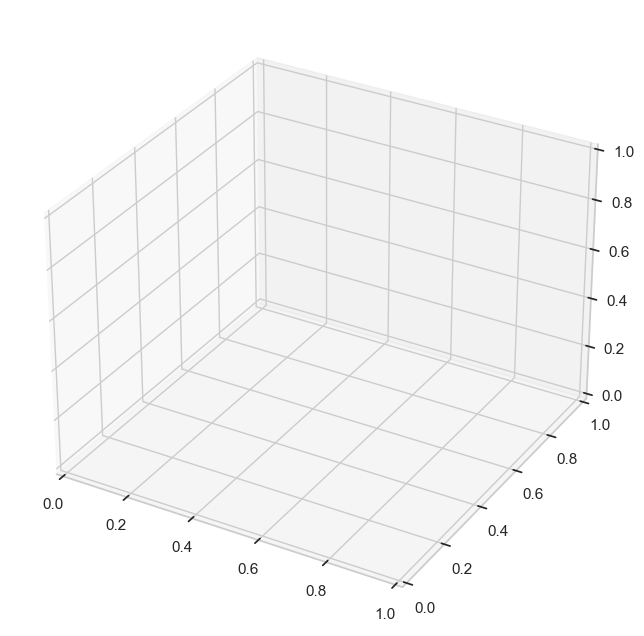

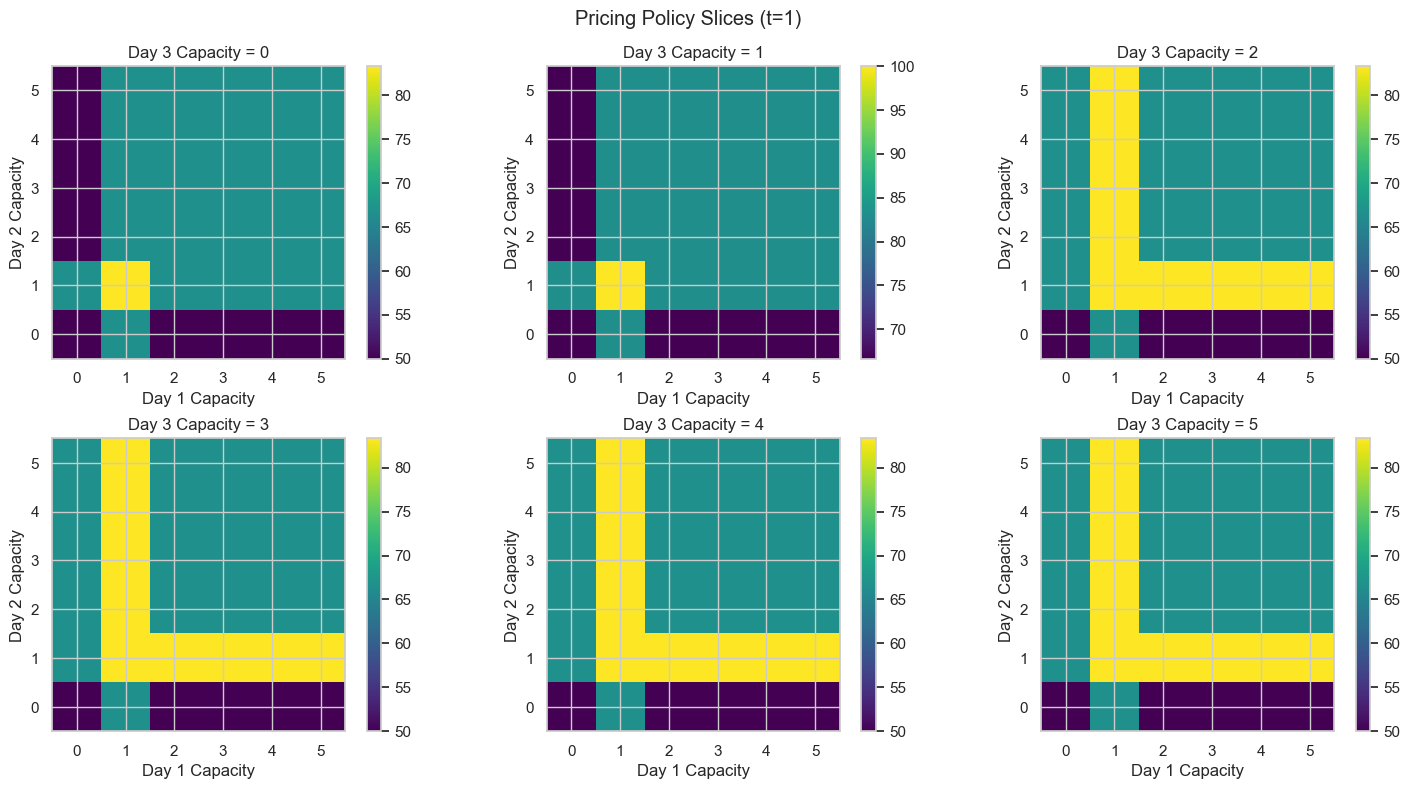

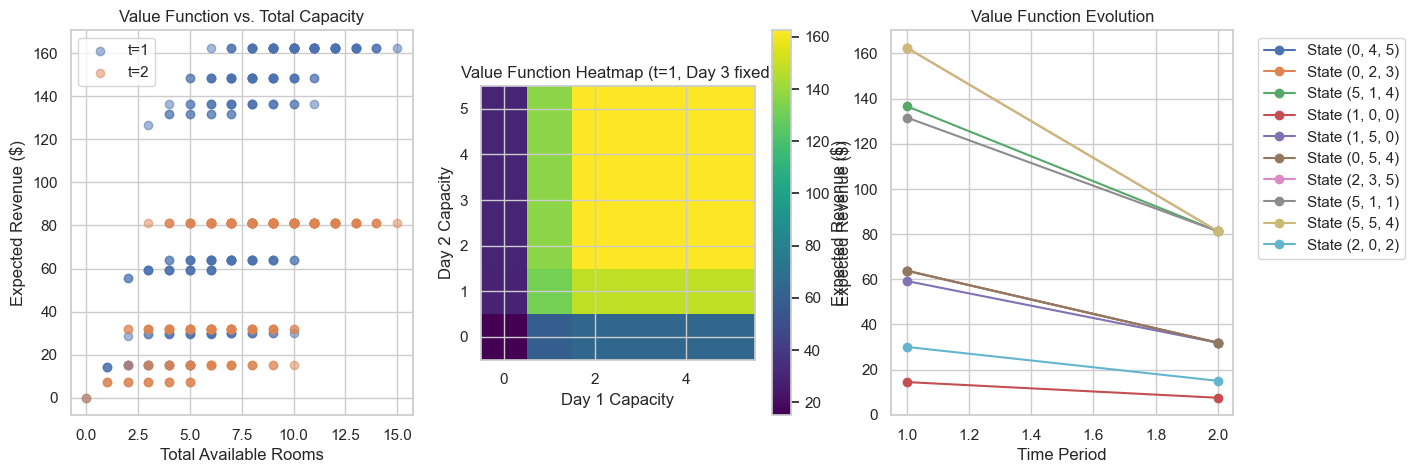

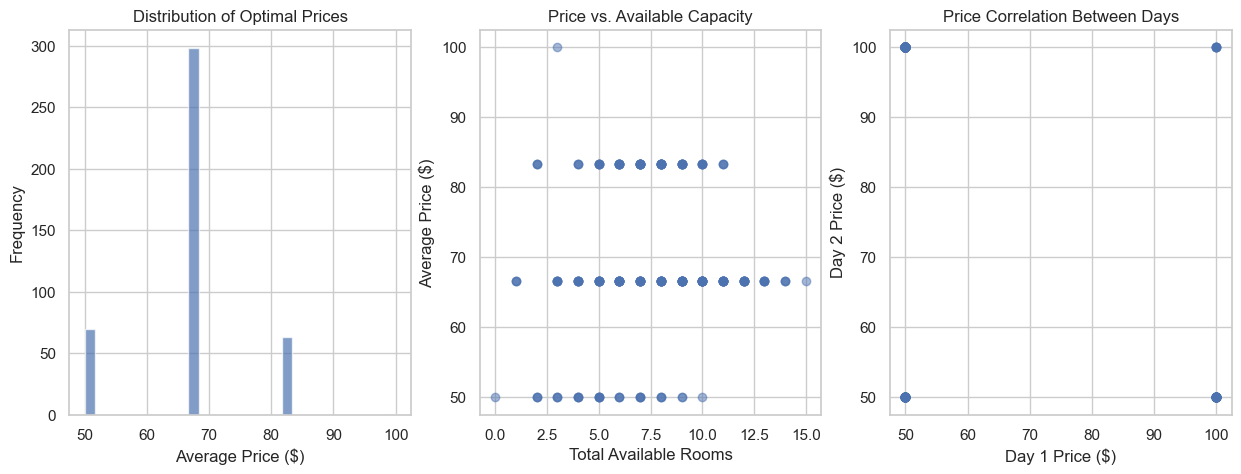

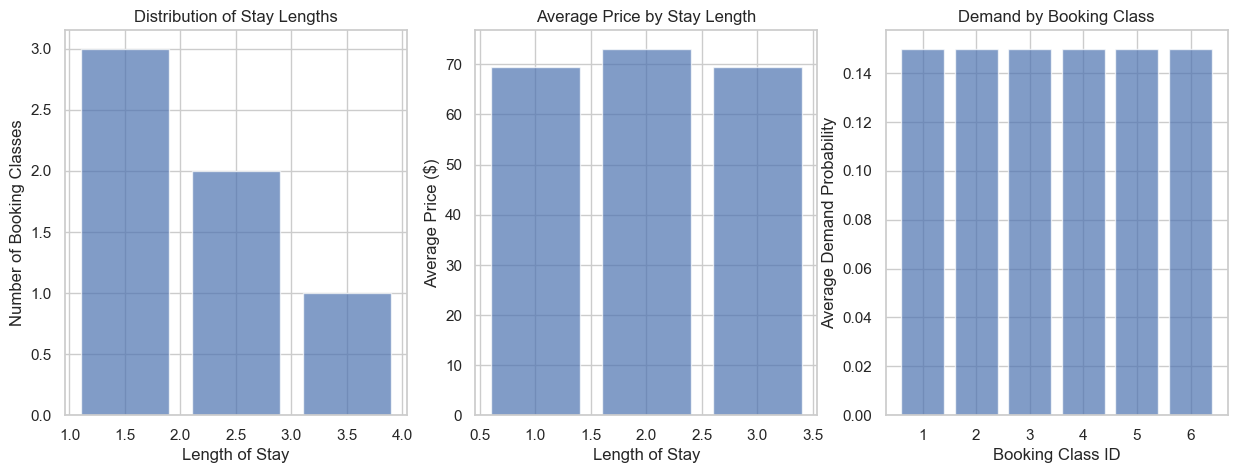

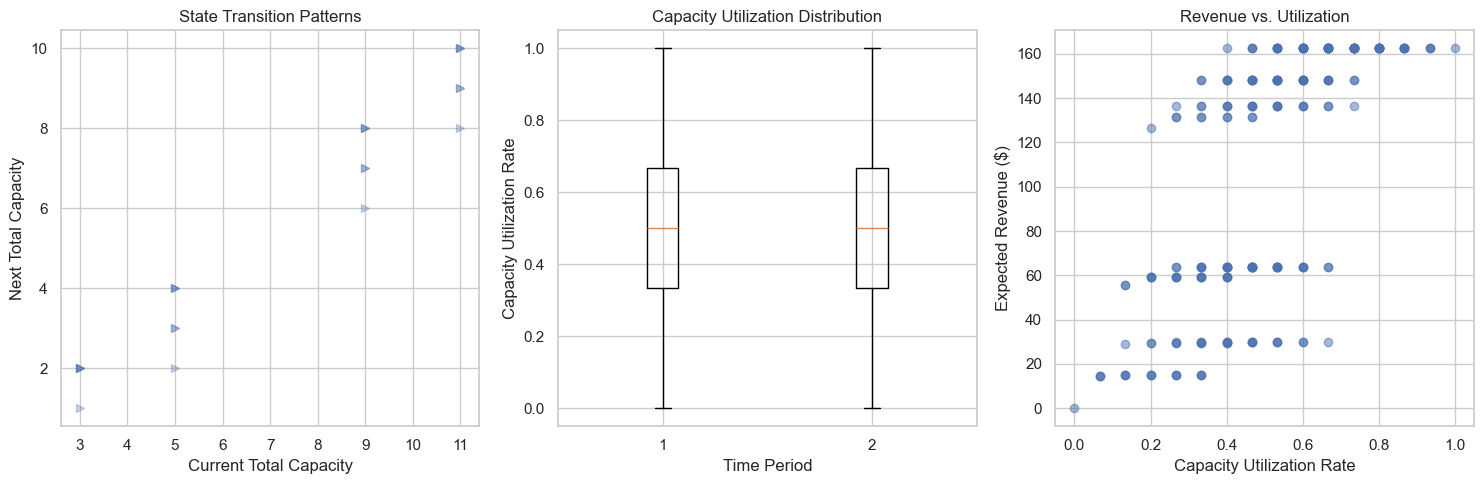

In [7]:
# Define parameters
params = ProblemParameters(
    N=3,              # 3-day service horizon
    T=2,              # 2 booking periods
    C=5,              # 5 rooms capacity
    price_min=50.0,   # Minimum price
    price_max=150.0,  # Maximum price
    price_levels=3,   # 3 discrete price levels
    arrival_prob_base=0.15  # Base arrival probability
)

# Create and solve model
model = DynamicPricingModel(params)
model.solve(use_parallel=False)  # Use sequential processing in notebook
model.visualize_results()

In [8]:
model.V

{(0, 0, 0): {1: 0.0, 2: 0.0, 3: 0.0},
 (0, 0, 1): {1: 14.4375, 2: 7.5, 3: 0.0},
 (0, 0, 2): {1: 15.0, 2: 7.5, 3: 0.0},
 (0, 0, 3): {1: 15.0, 2: 7.5, 3: 0.0},
 (0, 0, 4): {1: 15.0, 2: 7.5, 3: 0.0},
 (0, 0, 5): {1: 15.0, 2: 7.5, 3: 0.0},
 (0, 1, 0): {1: 14.4375, 2: 7.5, 3: 0.0},
 (0, 1, 1): {1: 55.828125, 2: 31.875, 3: 0.0},
 (0, 1, 2): {1: 59.1796875, 2: 31.875, 3: 0.0},
 (0, 1, 3): {1: 59.1796875, 2: 31.875, 3: 0.0},
 (0, 1, 4): {1: 59.1796875, 2: 31.875, 3: 0.0},
 (0, 1, 5): {1: 59.1796875, 2: 31.875, 3: 0.0},
 (0, 2, 0): {1: 15.0, 2: 7.5, 3: 0.0},
 (0, 2, 1): {1: 59.1796875, 2: 31.875, 3: 0.0},
 (0, 2, 2): {1: 63.75, 2: 31.875, 3: 0.0},
 (0, 2, 3): {1: 63.75, 2: 31.875, 3: 0.0},
 (0, 2, 4): {1: 63.75, 2: 31.875, 3: 0.0},
 (0, 2, 5): {1: 63.75, 2: 31.875, 3: 0.0},
 (0, 3, 0): {1: 15.0, 2: 7.5, 3: 0.0},
 (0, 3, 1): {1: 59.1796875, 2: 31.875, 3: 0.0},
 (0, 3, 2): {1: 63.75, 2: 31.875, 3: 0.0},
 (0, 3, 3): {1: 63.75, 2: 31.875, 3: 0.0},
 (0, 3, 4): {1: 63.75, 2: 31.875, 3: 0.0},
 (0, 3, 

In [9]:
model.policy

{(0, 0, 0): {1: (50.0, 50.0, 50.0), 2: (50.0, 50.0, 50.0)},
 (0, 0, 1): {1: (50.0, 50.0, 100.0), 2: (50.0, 50.0, 50.0)},
 (0, 0, 2): {1: (50.0, 50.0, 50.0), 2: (50.0, 50.0, 50.0)},
 (0, 0, 3): {1: (50.0, 50.0, 50.0), 2: (50.0, 50.0, 50.0)},
 (0, 0, 4): {1: (50.0, 50.0, 50.0), 2: (50.0, 50.0, 50.0)},
 (0, 0, 5): {1: (50.0, 50.0, 50.0), 2: (50.0, 50.0, 50.0)},
 (0, 1, 0): {1: (50.0, 100.0, 50.0), 2: (50.0, 50.0, 50.0)},
 (0, 1, 1): {1: (50.0, 100.0, 100.0), 2: (50.0, 50.0, 100.0)},
 (0, 1, 2): {1: (50.0, 100.0, 50.0), 2: (50.0, 50.0, 100.0)},
 (0, 1, 3): {1: (50.0, 100.0, 50.0), 2: (50.0, 50.0, 100.0)},
 (0, 1, 4): {1: (50.0, 100.0, 50.0), 2: (50.0, 50.0, 100.0)},
 (0, 1, 5): {1: (50.0, 100.0, 50.0), 2: (50.0, 50.0, 100.0)},
 (0, 2, 0): {1: (50.0, 50.0, 50.0), 2: (50.0, 50.0, 50.0)},
 (0, 2, 1): {1: (50.0, 50.0, 100.0), 2: (50.0, 50.0, 100.0)},
 (0, 2, 2): {1: (50.0, 50.0, 100.0), 2: (50.0, 50.0, 100.0)},
 (0, 2, 3): {1: (50.0, 50.0, 100.0), 2: (50.0, 50.0, 100.0)},
 (0, 2, 4): {1: (50.0